## Stochastic Gradient Descent

To adjust the weights and biases using the derivatives gathered from back propagtion, Stochastic Gradient Descent will be used. Three hyperparemters will be used to ensure the global minimum will be reached: a learning rate, a learning rate decay and momentum.


In [23]:
# Import relavant modules
from spiral_data import spiral_data
from neuralNetworkClasses.cost_functions import *
from neuralNetworkClasses.layer_dense import *
import sys
import numpy as np

# Append file path to system's path
sys.path.append('..')

# Import class objects for the neural network and spiral data


In [24]:
# SGD optimiser class
class Optimizer_SGD:
    # Initialise optimiser and set default params
    def __init__(self, learning_rate=1.0, decay=0.0, momentum=0.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        # If decay argument, apply decay to current learning rate calculations
        self.current_learning_rate = self.learning_rate * \
            (1.0 / (1.0 + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If momentum was passed
        if self.momentum:
            # If layer output does not contain momentum arrays
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Update bias
            bias_updates = self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # If no momentum is used
        else:
            weight_updates = -self.current_learning_rate * \
                layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        # Update weights and biases
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after a params update
    def post_update_params(self):
        self.iterations += 1

Test the optimising function using the spiral data


In [29]:
# Create spiral data
X_train, y_train = spiral_data(300, 3)

# Initiate instances of NN classes. We need more neurons in the hidden layer to make it more accurate.
hidden_layer = LayerDense(2, 50)
ReLU = ActivationRelU()
output_layer = LayerDense(50, 3)
softmax_cost = ActivationSoftmaxCost()

# Create optimiser instance object
sgd = Optimizer_SGD(decay=1e-3, momentum=0.9)

# Train in epochs. 10001 iterations.
for epoch in range(10001):
    # Forward propagation
    hidden_layer.forward(X_train)
    ReLU.forward(hidden_layer.output)
    output_layer.forward(ReLU.output)

    # Calculate error
    cost = softmax_cost.forward(output_layer.output, y_train)

    # Calculate accuracy from output of softmax and y
    predictions = np.argmax(softmax_cost.output, axis=1)
    accuracy = np.mean(predictions == y_train)

    # Print statistics per set of epochs
    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {cost:.3f}, ' +
              f'lr: {sgd.current_learning_rate}')

    # Back propagation
    softmax_cost.backward(softmax_cost.output, y_train)
    output_layer.backward(softmax_cost.dinputs)
    ReLU.backward(output_layer.dinputs)
    hidden_layer.backward(ReLU.dinputs)

    # Update weights and biases
    sgd.pre_update_params()
    sgd.update_params(hidden_layer)
    sgd.update_params(output_layer)
    sgd.post_update_params()


epoch: 0, acc: 0.346, loss: 1.099, lr: 1.0
epoch: 100, acc: 0.461, loss: 1.034, lr: 0.9099181073703367
epoch: 200, acc: 0.466, loss: 0.950, lr: 0.8340283569641367
epoch: 300, acc: 0.626, loss: 0.825, lr: 0.7698229407236336
epoch: 400, acc: 0.590, loss: 0.860, lr: 0.7147962830593281
epoch: 500, acc: 0.758, loss: 0.545, lr: 0.66711140760507
epoch: 600, acc: 0.781, loss: 0.489, lr: 0.6253908692933083
epoch: 700, acc: 0.812, loss: 0.428, lr: 0.5885815185403178
epoch: 800, acc: 0.846, loss: 0.382, lr: 0.5558643690939411
epoch: 900, acc: 0.869, loss: 0.349, lr: 0.526592943654555
epoch: 1000, acc: 0.871, loss: 0.327, lr: 0.5002501250625312
epoch: 1100, acc: 0.882, loss: 0.309, lr: 0.4764173415912339
epoch: 1200, acc: 0.891, loss: 0.291, lr: 0.45475216007276037
epoch: 1300, acc: 0.891, loss: 0.287, lr: 0.43497172683775553
epoch: 1400, acc: 0.896, loss: 0.276, lr: 0.4168403501458941
epoch: 1500, acc: 0.897, loss: 0.270, lr: 0.4001600640256102
epoch: 1600, acc: 0.901, loss: 0.265, lr: 0.38476337

The neural network achieved 93 % accuracy after 100000 epochs. To achieve a greater accuracy, further hyper parameters will need to be added such L1 and L2 regularisation. The neural network can be tested using new spiral data.


In [30]:
# Create test dataset
X_test, y_test = spiral_data(100, 3)

# Pass dataset through the neural network with updated final params
hidden_layer.forward(X_test)
ReLU.forward(hidden_layer.output)
output_layer.forward(ReLU.output)
cost = softmax_cost.forward(output_layer.output, y_test)

# Calculate accuracy and loss for the test dataset
predictions = np.argmax(softmax_cost.output, axis=1)
# If y_test is one hot encoded, convert to scalar values
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)

# Print statistics
print(f'test, acc: {accuracy:.3f}, loss: {cost:.3f}')


test, acc: 0.853, loss: 0.588


The test dataset achieved 85% percent accuracy. This can be improved by increasing the number of samples in the training set, the number of neurons in the hidden layer or the amount of epochs during training.


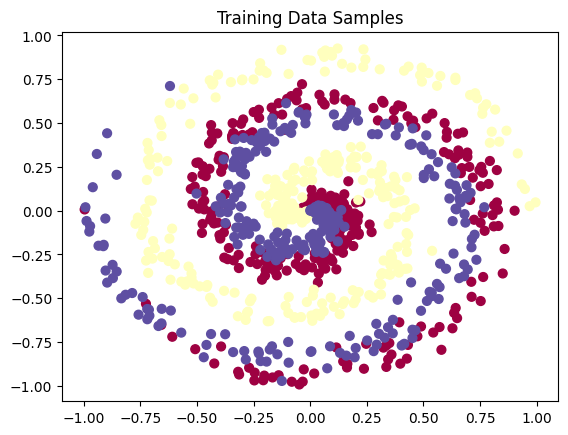

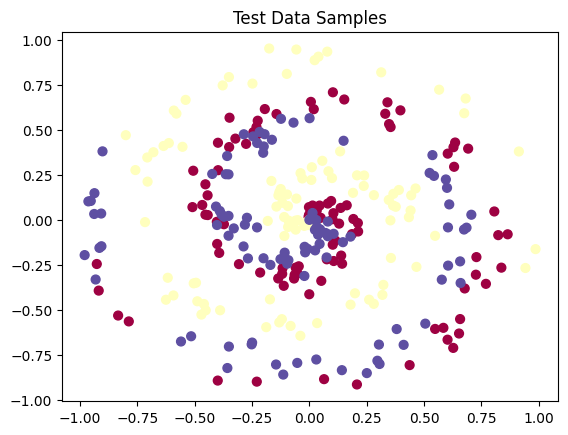

In [31]:
# Modules
import matplotlib.pyplot as plt

# Plot training data
plt.scatter(X_train[:, 0], X_train[:, 1],
            c=y_train, s=40, cmap=plt.cm.Spectral)
plt.title("Training Data Samples")
plt.show()

# Plot test data
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.Spectral)
plt.title("Test Data Samples")
plt.show()
